In [1]:
%load_ext autoreload
%autoreload 2
%reset -f
from custom_imports import *
import tensorflow as tf
from tensorflow import keras

In [2]:
data_root = "data/"
n_muscles = 9

In [3]:
from functools import reduce
bad_stuff = reduce(lambda x, y: set(x) | set(y), map(joblib.load, glob.glob(data_root+"bad*")))

In [4]:
image_names = joblib.load(data_root+"image_names.pkl")
classes     = {k: v for k, v in joblib.load(data_root+"multi_label_images.dict").items() 
               if k not in bad_stuff and len(np.unique(v))==n_muscles+1}

In [5]:
raw_images  = {k: v for k, v in zip(image_names, joblib.load(data_root+"raw_images.pkl")) 
               if k not in bad_stuff and k in classes}

In [6]:
def resize_mask(image, shape=(256, 256)):
    out = np.zeros(shape)
    for label in sorted(np.unique(image))[1:]:
        tmp = cv2.resize((image==label).astype('uint8'), shape[::-1])*label
        out = np.maximum(out, tmp)
    return out

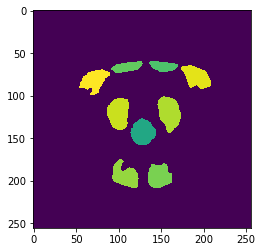

In [7]:
name = np.random.choice(list(classes.keys()))
plt.imshow(resize_mask(classes[name]))

In [8]:
client = Client(scheduler_file="/home/bzr0014/schedfile")

In [9]:
X = bag.from_sequence(list(raw_images.values())).map(np.mean, axis=2).map(cv2.resize, (256, 256))
Y = bag.from_sequence(list(classes.values())).map(resize_mask, (256, 256))

In [10]:
X = np.array(X.compute())/255
Y = np.array(Y.compute())
Y[Y>0] = Y[Y>0]/10 - 14
Y = Y.astype('uint8')

In [11]:
if len(X.shape) == 3:
    X = X.reshape(*X.shape, 1)
if len(Y.shape) == 3:
    Y = Y.reshape(*Y.shape, 1)

In [12]:
#Y = Y.reshape(Y.shape[0], -1)

In [36]:
from sklearn.model_selection import train_test_split
Xtr, Xts, Ytr, Yts = train_test_split(X, (Y)*1, test_size=.2, random_state=17)

In [37]:
Xtr = (Xtr - Xtr.mean(axis=(1, 2, 3), keepdims=True))/Xtr.std(axis=(1, 2, 3), keepdims=True)

In [38]:
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, ReLU, BatchNormalization, Input, Concatenate, Flatten, MaxPooling2D
from tensorflow.keras import Sequential
from tensorflow.keras import Model

In [39]:
inputs = Input(shape=[256, 256, 1])
c1 = Conv2D(24, (3, 3), 1, padding='same', use_bias=False)(inputs)
c1 = MaxPooling2D()(inputs)
c1 = BatchNormalization()(c1)
c1 = ReLU()(c1)
c2 = Conv2D(48, (3, 3), 1, padding='same', use_bias=False)(c1)
c2 = MaxPooling2D()(c2)
c2 = BatchNormalization()(c2)
c2 = ReLU()(c2)
c3 = Conv2D(96, (3, 3), 1, padding='same', use_bias=False)(c2)
c3 = MaxPooling2D()(c3)
c3 = BatchNormalization()(c3)
c3 = ReLU()(c3)
c4 = Conv2DTranspose(48, (3, 3), 2, padding='same', use_bias=False)(c3)
#c4 = Concatenate()([c40, c2])
#c4 = c40 + c2
c4 = BatchNormalization()(c4)
c4 = ReLU()(c4)
c5 = Conv2DTranspose(24, (3, 3), 2, padding='same', use_bias=False)(c4)
#c5 = Concatenate()([c50, c1])
#c5 = c50 + c1
c5 = BatchNormalization()(c5)
c5 = ReLU()(c5)
c6 = Conv2DTranspose(24, (3, 3), 2, padding='same', use_bias=False)(c5)
#c6 = Concatenate()([c60, inputs])
#c6 = c60 + inputs
c6 = BatchNormalization()(c6)
c6 = ReLU()(c6)
output = Conv2D(12, (1, 1), padding='same')(c6)
model = Model(inputs=[inputs], outputs=[output])

In [97]:
input_ = tf.keras.layers.Input(shape=(None, None, 1))
x = tf.keras.layers.Conv2D(16, (3, 3), strides=2, padding="same", use_bias=False)(input_)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ELU()(x)
s = x
x = tf.keras.layers.Conv2D(32, (3, 3), strides=2, padding="same", use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ELU()(x)
x = tf.keras.layers.Conv2D(64, (3, 3), strides=2, padding="same", use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ELU()(x)
x = tf.keras.layers.Conv2D(128, (4, 4), strides=4, padding="same", use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ELU()(x)
x = tf.keras.layers.Conv2D(128, (4, 4), strides=2, padding="same", use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ELU()(x)
x = tf.keras.layers.Dropout(.3)(x)
x = tf.keras.layers.Conv2D(256, (1, 1), strides=1, padding="valid", use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ELU()(x)
x = tf.keras.layers.Conv2D(12, (1, 1), strides=1, padding="valid", use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ELU()(x)
x = tf.keras.layers.Conv2DTranspose(16, (4, 4), strides=4, padding="same", use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ELU()(x)
x = tf.keras.layers.Conv2DTranspose(16, (4, 4), strides=4, padding="same", use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ELU()(x)
x = tf.keras.layers.Conv2DTranspose(16, (4, 4), strides=2, padding="same", use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ELU()(x) + s
x = tf.keras.layers.Conv2DTranspose(12, (4, 4), strides=2, padding="same", activation="softmax")(x)
#x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.ELU()(x)
#x = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same", use_bias=False)(x)
#x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.ELU()(x)
#x = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same", use_bias=False)(x)
#x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.ELU()(x)
#x = tf.keras.layers.Conv2DTranspose(16, (3, 3), strides=2, padding="same", use_bias=False)(x)
#x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.ELU()(x)
model = tf.keras.Model(inputs = [input_], outputs=[x])

In [98]:
Xtr.shape, Ytr.shape

((100, 256, 256, 1), (100, 256, 256, 1))

In [99]:
optimizer = tf.keras.optimizers.Adam(1e-4)
model.compile(optimizer, loss=tf.keras.losses.sparse_categorical_crossentropy, 
              metrics=['accuracy'])

In [100]:
model.fit(Xtr, Ytr, epochs=1000, validation_split=.2, shuffle=True, batch_size=16,
         callbacks=[
             tf.keras.callbacks.EarlyStopping(monitor="val_acc", patience=30),
             tf.keras.callbacks.ModelCheckpoint("models/new_era.v02.9muscles.h5", monitor="val_acc", save_best_only=True),
         ]
        )

Train on 80 samples, validate on 20 samples
Epoch 1/1000
80/80 [==============================] - 27s 335ms/sample - loss: 2.6401 - acc: 0.1042 - val_loss: 2.4865 - val_acc: 0.1292
Epoch 2/1000
80/80 [==============================] - 5s 62ms/sample - loss: 2.6173 - acc: 0.1096 - val_loss: 2.4823 - val_acc: 0.1342
Epoch 3/1000
80/80 [==============================] - 5s 62ms/sample - loss: 2.5956 - acc: 0.1165 - val_loss: 2.4779 - val_acc: 0.1380
Epoch 4/1000
80/80 [==============================] - 5s 59ms/sample - loss: 2.5749 - acc: 0.1234 - val_loss: 2.4733 - val_acc: 0.1416
Epoch 5/1000
80/80 [==============================] - 5s 59ms/sample - loss: 2.5547 - acc: 0.1309 - val_loss: 2.4685 - val_acc: 0.1451
Epoch 6/1000
80/80 [==============================] - 5s 61ms/sample - loss: 2.5346 - acc: 0.1396 - val_loss: 2.4634 - val_acc: 0.1486
Epoch 7/1000
80/80 [==============================] - 5s 62ms/sample - loss: 2.5150 - acc: 0.1491 - val_loss: 2.4580 - val_acc: 0.1522
Epoch 8/1

Epoch 61/1000
80/80 [==============================] - 6s 75ms/sample - loss: 1.3006 - acc: 0.7899 - val_loss: 1.3563 - val_acc: 0.8056
Epoch 62/1000
80/80 [==============================] - 6s 79ms/sample - loss: 1.2837 - acc: 0.7917 - val_loss: 1.3280 - val_acc: 0.8118
Epoch 63/1000
80/80 [==============================] - 6s 75ms/sample - loss: 1.2689 - acc: 0.7966 - val_loss: 1.3081 - val_acc: 0.8112
Epoch 64/1000
80/80 [==============================] - 6s 79ms/sample - loss: 1.2532 - acc: 0.7967 - val_loss: 1.2935 - val_acc: 0.8125
Epoch 65/1000
80/80 [==============================] - 6s 78ms/sample - loss: 1.2390 - acc: 0.8014 - val_loss: 1.2770 - val_acc: 0.8122
Epoch 66/1000
80/80 [==============================] - 6s 79ms/sample - loss: 1.2226 - acc: 0.8019 - val_loss: 1.2428 - val_acc: 0.8159
Epoch 67/1000
80/80 [==============================] - 6s 78ms/sample - loss: 1.2092 - acc: 0.8054 - val_loss: 1.2238 - val_acc: 0.8169
Epoch 68/1000
80/80 [===========================

80/80 [==============================] - 6s 76ms/sample - loss: 0.6978 - acc: 0.8675 - val_loss: 0.6987 - val_acc: 0.8634
Epoch 122/1000
80/80 [==============================] - 6s 79ms/sample - loss: 0.6929 - acc: 0.8672 - val_loss: 0.6976 - val_acc: 0.8646
Epoch 123/1000
80/80 [==============================] - 6s 77ms/sample - loss: 0.6865 - acc: 0.8682 - val_loss: 0.6926 - val_acc: 0.8641
Epoch 124/1000
80/80 [==============================] - 6s 79ms/sample - loss: 0.6800 - acc: 0.8684 - val_loss: 0.6882 - val_acc: 0.8651
Epoch 125/1000
80/80 [==============================] - 6s 80ms/sample - loss: 0.6747 - acc: 0.8692 - val_loss: 0.6819 - val_acc: 0.8655
Epoch 126/1000
80/80 [==============================] - 6s 79ms/sample - loss: 0.6702 - acc: 0.8699 - val_loss: 0.6808 - val_acc: 0.8664
Epoch 127/1000
80/80 [==============================] - 6s 75ms/sample - loss: 0.6644 - acc: 0.8707 - val_loss: 0.6771 - val_acc: 0.8660
Epoch 128/1000
80/80 [==============================] - 

Epoch 181/1000
80/80 [==============================] - 6s 79ms/sample - loss: 0.4390 - acc: 0.8977 - val_loss: 0.4836 - val_acc: 0.8909
Epoch 182/1000
80/80 [==============================] - 6s 80ms/sample - loss: 0.4364 - acc: 0.8979 - val_loss: 0.4810 - val_acc: 0.8913
Epoch 183/1000
80/80 [==============================] - 6s 78ms/sample - loss: 0.4329 - acc: 0.8983 - val_loss: 0.4791 - val_acc: 0.8917
Epoch 184/1000
80/80 [==============================] - 6s 77ms/sample - loss: 0.4306 - acc: 0.8983 - val_loss: 0.4757 - val_acc: 0.8916
Epoch 185/1000
80/80 [==============================] - 6s 78ms/sample - loss: 0.4283 - acc: 0.8989 - val_loss: 0.4737 - val_acc: 0.8921
Epoch 186/1000
80/80 [==============================] - 6s 79ms/sample - loss: 0.4269 - acc: 0.8991 - val_loss: 0.4705 - val_acc: 0.8923
Epoch 187/1000
80/80 [==============================] - 6s 78ms/sample - loss: 0.4241 - acc: 0.8992 - val_loss: 0.4692 - val_acc: 0.8922
Epoch 188/1000
80/80 [===================

Epoch 241/1000
80/80 [==============================] - 6s 80ms/sample - loss: 0.3373 - acc: 0.9121 - val_loss: 0.3777 - val_acc: 0.9051
Epoch 242/1000
80/80 [==============================] - 6s 78ms/sample - loss: 0.3350 - acc: 0.9127 - val_loss: 0.3765 - val_acc: 0.9051
Epoch 243/1000
80/80 [==============================] - 6s 79ms/sample - loss: 0.3333 - acc: 0.9130 - val_loss: 0.3755 - val_acc: 0.9052
Epoch 244/1000
80/80 [==============================] - 6s 79ms/sample - loss: 0.3332 - acc: 0.9133 - val_loss: 0.3749 - val_acc: 0.9056
Epoch 245/1000
80/80 [==============================] - 6s 78ms/sample - loss: 0.3313 - acc: 0.9134 - val_loss: 0.3738 - val_acc: 0.9052
Epoch 246/1000
80/80 [==============================] - 6s 80ms/sample - loss: 0.3300 - acc: 0.9136 - val_loss: 0.3717 - val_acc: 0.9061
Epoch 247/1000
80/80 [==============================] - 6s 79ms/sample - loss: 0.3291 - acc: 0.9137 - val_loss: 0.3698 - val_acc: 0.9065
Epoch 248/1000
80/80 [===================

Epoch 301/1000
80/80 [==============================] - 6s 76ms/sample - loss: 0.2716 - acc: 0.9269 - val_loss: 0.3060 - val_acc: 0.9196
Epoch 302/1000
80/80 [==============================] - 6s 79ms/sample - loss: 0.2701 - acc: 0.9272 - val_loss: 0.3053 - val_acc: 0.9204
Epoch 303/1000
80/80 [==============================] - 6s 76ms/sample - loss: 0.2681 - acc: 0.9278 - val_loss: 0.3042 - val_acc: 0.9204
Epoch 304/1000
80/80 [==============================] - 6s 79ms/sample - loss: 0.2682 - acc: 0.9276 - val_loss: 0.3026 - val_acc: 0.9208
Epoch 305/1000
80/80 [==============================] - 6s 80ms/sample - loss: 0.2673 - acc: 0.9275 - val_loss: 0.3015 - val_acc: 0.9212
Epoch 306/1000
80/80 [==============================] - 6s 79ms/sample - loss: 0.2656 - acc: 0.9286 - val_loss: 0.3000 - val_acc: 0.9216
Epoch 307/1000
80/80 [==============================] - 6s 77ms/sample - loss: 0.2641 - acc: 0.9285 - val_loss: 0.2995 - val_acc: 0.9214
Epoch 308/1000
80/80 [===================

Epoch 361/1000
80/80 [==============================] - 6s 79ms/sample - loss: 0.2145 - acc: 0.9445 - val_loss: 0.2531 - val_acc: 0.9360
Epoch 362/1000
80/80 [==============================] - 6s 79ms/sample - loss: 0.2137 - acc: 0.9450 - val_loss: 0.2518 - val_acc: 0.9366
Epoch 363/1000
80/80 [==============================] - 6s 78ms/sample - loss: 0.2118 - acc: 0.9458 - val_loss: 0.2505 - val_acc: 0.9370
Epoch 364/1000
80/80 [==============================] - 6s 80ms/sample - loss: 0.2118 - acc: 0.9453 - val_loss: 0.2494 - val_acc: 0.9373
Epoch 365/1000
80/80 [==============================] - 6s 78ms/sample - loss: 0.2098 - acc: 0.9462 - val_loss: 0.2487 - val_acc: 0.9376
Epoch 366/1000
80/80 [==============================] - 6s 80ms/sample - loss: 0.2097 - acc: 0.9462 - val_loss: 0.2475 - val_acc: 0.9382
Epoch 367/1000
80/80 [==============================] - 6s 80ms/sample - loss: 0.2094 - acc: 0.9462 - val_loss: 0.2460 - val_acc: 0.9387
Epoch 368/1000
80/80 [===================

Epoch 438/1000
80/80 [==============================] - 6s 76ms/sample - loss: 0.1415 - acc: 0.9657 - val_loss: 0.1690 - val_acc: 0.9572
Epoch 439/1000
80/80 [==============================] - 6s 77ms/sample - loss: 0.1402 - acc: 0.9661 - val_loss: 0.1672 - val_acc: 0.9574
Epoch 440/1000
80/80 [==============================] - 6s 76ms/sample - loss: 0.1417 - acc: 0.9658 - val_loss: 0.1676 - val_acc: 0.9574
Epoch 441/1000
80/80 [==============================] - 6s 76ms/sample - loss: 0.1394 - acc: 0.9659 - val_loss: 0.1683 - val_acc: 0.9572
Epoch 442/1000
80/80 [==============================] - 6s 79ms/sample - loss: 0.1378 - acc: 0.9663 - val_loss: 0.1665 - val_acc: 0.9575
Epoch 443/1000
80/80 [==============================] - 6s 78ms/sample - loss: 0.1384 - acc: 0.9666 - val_loss: 0.1651 - val_acc: 0.9578
Epoch 444/1000
80/80 [==============================] - 6s 77ms/sample - loss: 0.1392 - acc: 0.9660 - val_loss: 0.1650 - val_acc: 0.9577
Epoch 445/1000
80/80 [===================

Epoch 498/1000
80/80 [==============================] - 6s 79ms/sample - loss: 0.1101 - acc: 0.9707 - val_loss: 0.1373 - val_acc: 0.9618
Epoch 499/1000
80/80 [==============================] - 6s 77ms/sample - loss: 0.1089 - acc: 0.9708 - val_loss: 0.1377 - val_acc: 0.9618
Epoch 500/1000
80/80 [==============================] - 6s 79ms/sample - loss: 0.1085 - acc: 0.9710 - val_loss: 0.1360 - val_acc: 0.9620
Epoch 501/1000
80/80 [==============================] - 6s 77ms/sample - loss: 0.1102 - acc: 0.9702 - val_loss: 0.1364 - val_acc: 0.9617
Epoch 502/1000
80/80 [==============================] - 6s 77ms/sample - loss: 0.1081 - acc: 0.9710 - val_loss: 0.1361 - val_acc: 0.9618
Epoch 503/1000
80/80 [==============================] - 6s 80ms/sample - loss: 0.1068 - acc: 0.9711 - val_loss: 0.1353 - val_acc: 0.9620
Epoch 504/1000
80/80 [==============================] - 6s 78ms/sample - loss: 0.1081 - acc: 0.9707 - val_loss: 0.1350 - val_acc: 0.9621
Epoch 505/1000
80/80 [===================

Epoch 558/1000
80/80 [==============================] - 6s 76ms/sample - loss: 0.0922 - acc: 0.9735 - val_loss: 0.1220 - val_acc: 0.9639
Epoch 559/1000
80/80 [==============================] - 6s 74ms/sample - loss: 0.0936 - acc: 0.9729 - val_loss: 0.1222 - val_acc: 0.9639
Epoch 560/1000
80/80 [==============================] - 6s 75ms/sample - loss: 0.0921 - acc: 0.9735 - val_loss: 0.1218 - val_acc: 0.9640
Epoch 561/1000
80/80 [==============================] - 6s 76ms/sample - loss: 0.0918 - acc: 0.9736 - val_loss: 0.1210 - val_acc: 0.9639
Epoch 562/1000
80/80 [==============================] - 6s 76ms/sample - loss: 0.0922 - acc: 0.9735 - val_loss: 0.1207 - val_acc: 0.9640
Epoch 563/1000
80/80 [==============================] - 6s 79ms/sample - loss: 0.0933 - acc: 0.9729 - val_loss: 0.1203 - val_acc: 0.9643
Epoch 564/1000
80/80 [==============================] - 6s 77ms/sample - loss: 0.0915 - acc: 0.9735 - val_loss: 0.1206 - val_acc: 0.9642
Epoch 565/1000
80/80 [===================

Epoch 618/1000
80/80 [==============================] - 6s 80ms/sample - loss: 0.0812 - acc: 0.9755 - val_loss: 0.1113 - val_acc: 0.9657
Epoch 619/1000
80/80 [==============================] - 6s 76ms/sample - loss: 0.0811 - acc: 0.9755 - val_loss: 0.1122 - val_acc: 0.9654
Epoch 620/1000
80/80 [==============================] - 6s 74ms/sample - loss: 0.0804 - acc: 0.9757 - val_loss: 0.1130 - val_acc: 0.9654
Epoch 621/1000
80/80 [==============================] - 6s 77ms/sample - loss: 0.0806 - acc: 0.9757 - val_loss: 0.1123 - val_acc: 0.9657
Epoch 622/1000
80/80 [==============================] - 6s 79ms/sample - loss: 0.0811 - acc: 0.9756 - val_loss: 0.1122 - val_acc: 0.9657
Epoch 623/1000
80/80 [==============================] - 6s 76ms/sample - loss: 0.0816 - acc: 0.9751 - val_loss: 0.1121 - val_acc: 0.9656
Epoch 624/1000
80/80 [==============================] - 6s 76ms/sample - loss: 0.0804 - acc: 0.9756 - val_loss: 0.1125 - val_acc: 0.9654
Epoch 625/1000
80/80 [===================

Epoch 678/1000
80/80 [==============================] - 6s 76ms/sample - loss: 0.0737 - acc: 0.9774 - val_loss: 0.1064 - val_acc: 0.9672
Epoch 679/1000
80/80 [==============================] - 6s 76ms/sample - loss: 0.0736 - acc: 0.9773 - val_loss: 0.1060 - val_acc: 0.9673
Epoch 680/1000
80/80 [==============================] - 6s 79ms/sample - loss: 0.0737 - acc: 0.9775 - val_loss: 0.1058 - val_acc: 0.9674
Epoch 681/1000
80/80 [==============================] - 6s 77ms/sample - loss: 0.0738 - acc: 0.9772 - val_loss: 0.1064 - val_acc: 0.9672
Epoch 682/1000
80/80 [==============================] - 6s 76ms/sample - loss: 0.0731 - acc: 0.9775 - val_loss: 0.1059 - val_acc: 0.9672
Epoch 683/1000
80/80 [==============================] - 6s 77ms/sample - loss: 0.0729 - acc: 0.9776 - val_loss: 0.1062 - val_acc: 0.9671
Epoch 684/1000
80/80 [==============================] - 6s 76ms/sample - loss: 0.0726 - acc: 0.9778 - val_loss: 0.1066 - val_acc: 0.9671
Epoch 685/1000
80/80 [===================

Epoch 738/1000
80/80 [==============================] - 6s 77ms/sample - loss: 0.0669 - acc: 0.9797 - val_loss: 0.1011 - val_acc: 0.9690
Epoch 739/1000
80/80 [==============================] - 6s 77ms/sample - loss: 0.0675 - acc: 0.9793 - val_loss: 0.1008 - val_acc: 0.9691
Epoch 740/1000
80/80 [==============================] - 6s 76ms/sample - loss: 0.0672 - acc: 0.9797 - val_loss: 0.0999 - val_acc: 0.9693
Epoch 741/1000
80/80 [==============================] - 6s 78ms/sample - loss: 0.0678 - acc: 0.9794 - val_loss: 0.0997 - val_acc: 0.9694
Epoch 742/1000
80/80 [==============================] - 6s 78ms/sample - loss: 0.0678 - acc: 0.9794 - val_loss: 0.0996 - val_acc: 0.9691
Epoch 743/1000
80/80 [==============================] - 6s 77ms/sample - loss: 0.0676 - acc: 0.9794 - val_loss: 0.0995 - val_acc: 0.9691
Epoch 744/1000
80/80 [==============================] - 6s 76ms/sample - loss: 0.0673 - acc: 0.9793 - val_loss: 0.1001 - val_acc: 0.9692
Epoch 745/1000
80/80 [===================

Epoch 798/1000
80/80 [==============================] - 6s 76ms/sample - loss: 0.0612 - acc: 0.9813 - val_loss: 0.0964 - val_acc: 0.9706
Epoch 799/1000
80/80 [==============================] - 6s 75ms/sample - loss: 0.0618 - acc: 0.9810 - val_loss: 0.0958 - val_acc: 0.9705
Epoch 800/1000
80/80 [==============================] - 6s 77ms/sample - loss: 0.0616 - acc: 0.9812 - val_loss: 0.0954 - val_acc: 0.9706
Epoch 801/1000
80/80 [==============================] - 6s 79ms/sample - loss: 0.0627 - acc: 0.9808 - val_loss: 0.0952 - val_acc: 0.9707
Epoch 802/1000
80/80 [==============================] - 6s 77ms/sample - loss: 0.0614 - acc: 0.9811 - val_loss: 0.0954 - val_acc: 0.9707
Epoch 803/1000
80/80 [==============================] - 6s 75ms/sample - loss: 0.0607 - acc: 0.9814 - val_loss: 0.0957 - val_acc: 0.9706
Epoch 804/1000
80/80 [==============================] - 6s 78ms/sample - loss: 0.0609 - acc: 0.9813 - val_loss: 0.0957 - val_acc: 0.9705
Epoch 805/1000
80/80 [===================

Epoch 858/1000
80/80 [==============================] - 6s 78ms/sample - loss: 0.0577 - acc: 0.9819 - val_loss: 0.0918 - val_acc: 0.9713
Epoch 859/1000
80/80 [==============================] - 6s 75ms/sample - loss: 0.0568 - acc: 0.9821 - val_loss: 0.0919 - val_acc: 0.9712
Epoch 860/1000
80/80 [==============================] - 6s 74ms/sample - loss: 0.0567 - acc: 0.9822 - val_loss: 0.0931 - val_acc: 0.9710
Epoch 861/1000
80/80 [==============================] - 6s 76ms/sample - loss: 0.0569 - acc: 0.9821 - val_loss: 0.0936 - val_acc: 0.9710
Epoch 862/1000
80/80 [==============================] - 6s 77ms/sample - loss: 0.0578 - acc: 0.9818 - val_loss: 0.0932 - val_acc: 0.9711
Epoch 863/1000
80/80 [==============================] - 6s 76ms/sample - loss: 0.0576 - acc: 0.9817 - val_loss: 0.0923 - val_acc: 0.9711
Epoch 864/1000
80/80 [==============================] - 6s 74ms/sample - loss: 0.0572 - acc: 0.9819 - val_loss: 0.0924 - val_acc: 0.9713
Epoch 865/1000
80/80 [===================

In [55]:
#mv models/new_era.v02.h5 models/new_era.v02.11muscles.h5

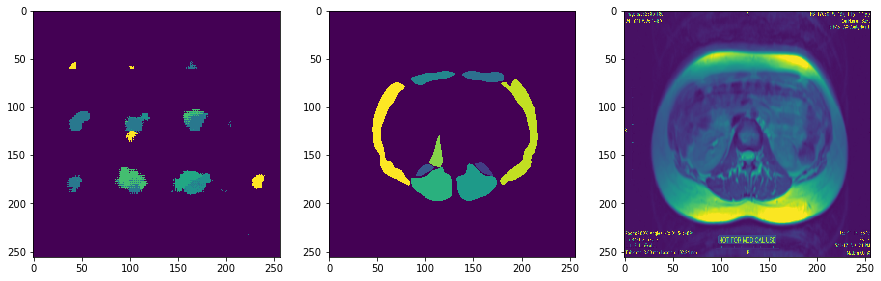

In [118]:
n = np.random.randint(len(Xts))
x = Xts[n:n+1]
res1 = model.predict(x)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(np.argmax(res1, axis=3)[0])
axes[1].imshow(Yts[n, :, :, 0])
axes[2].imshow(Xts[n, :, :, 0])

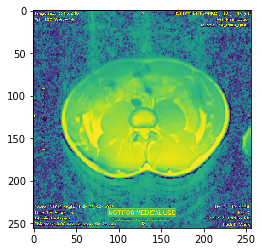

In [246]:

tmp.std(), x.std()
plt.imshow((tmp-tmp.mean())/tmp.std())

In [4]:
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, ReLU, BatchNormalization, Input, Concatenate, Flatten, MaxPooling2D
from tensorflow.keras import Sequential
from tensorflow.keras import Model
import tensorflow as tf

In [13]:
input_ = tf.keras.layers.Input(shape=(41, 41, 1))
hidden1 = tf.keras.layers.Conv2D(16, (15, 15), use_bias=False)(input_)
bn1 = tf.keras.layers.BatchNormalization()(hidden1)
r1 = tf.keras.layers.ELU()(bn1)
hidden2 = tf.keras.layers.Conv2D(1, (15, 15), use_bias=False)(r1)
bn2 = tf.keras.layers.BatchNormalization()(hidden2)
r2 = tf.keras.layers.ELU()(bn2)
small_input = tf.keras.layers.MaxPool2D([3, 3], 3)(input_)
concat = tf.keras.layers.concatenate([small_input, r2])
d1 = tf.keras.layers.Conv2D(100, (13, 13), activation='elu', use_bias=False)(concat)
bnd1 = tf.keras.layers.BatchNormalization()(d1)
d2 = tf.keras.layers.Conv2D(50, (1, 1), activation='elu', use_bias=False)(bnd1)
bnd2 = tf.keras.layers.BatchNormalization()(d2)
out = tf.keras.layers.Conv2D(12, (1, 1), use_bias=False, activation='relu')(bnd2)
kir = Conv2DTranspose(50, (1, 1), use_bias=False)(out)
#model = tf.keras.Model(inputs = [input_], outputs=[out])

In [53]:
s

<tf.Tensor 'conv2d_144/Conv2D:0' shape=(?, 8, 8, 32) dtype=float32>

In [526]:
def dense_to_cnn(layer, inp):
    weights = layer.get_weights()[0]
    w, h = weights.shape
    k1, k2, f = inp.shape[1:]
    f = np.transpose(np.reshape(weights, (f, k1, k2, h)), [1, 2, 0, 3])
    init = tf.keras.initializers.Constant(f)
    return Conv2D(h, (k1, k2), padding="valid", activation=layer.activation,
                  use_bias=layer.use_bias, kernel_initializer=init)(inp)

In [534]:
concat = tf.keras.layers.concatenate([m.layers[6].output, m.layers[7].output])
d1 = dense_to_cnn(m.layers[11], concat)
bnd1 = m.layers[12](tf.reshape(d1, (-1, 100)))
bnd1 = tf.reshape(bnd1, (-1, 1, 1, 100))
d2 = dense_to_cnn(m.layers[13], bnd1)
bnd2 = m.layers[14](tf.reshape(d2, (-1, 50)))
bnd2 = tf.reshape(bnd2, (-1, 1, 1, 50))
out = dense_to_cnn(m.layers[15], bnd2)

In [548]:
tf.keras.Sequential([m.layers[:5]])

TypeError: The added layer must be an instance of class Layer. Found: [<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x73df1d219470>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x73df1d2195f8>, <tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x73df1d219ac8>, <tensorflow.python.keras.layers.advanced_activations.ELU object at 0x73df1d219cf8>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x73df1d22d0f0>]

In [456]:
m.layers[1].get_weights()
bnd1 = tf.keras.layers.BatchNormalization()(d1)
d2 = tf.keras.layers.Dense(50, activation='elu', use_bias=False)(bnd1)
bnd2 = tf.keras.layers.BatchNormalization()(d2)
out = tf.keras.layers.Dense(12, use_bias=False, activation='sigmoid')(bnd2)
model = tf.keras.Model(inputs = [input_], outputs=[out])

[array([[[[ 0.4273322 , -0.66891664, -0.41082048, ...,  0.03281577,
           -0.8653048 , -0.29527175]],
 
         [[ 0.02195795, -0.26505286, -0.44935557, ..., -0.00866602,
           -0.5224701 , -0.0539092 ]],
 
         [[-0.23917915, -0.03932992, -0.3622652 , ..., -0.07664276,
           -0.32063457,  0.08171167]],
 
         ...,
 
         [[ 0.20957007, -0.07325549, -0.16613534, ..., -0.03821429,
            0.89720476,  0.80817664]],
 
         [[ 0.1956278 , -0.15037613, -0.40657434, ..., -0.09628498,
            0.7295852 ,  0.5108526 ]],
 
         [[ 0.14077339, -0.3146679 , -0.99406534, ..., -0.28412277,
            0.6733696 ,  0.19460006]]],
 
 
        [[[ 0.57008845, -0.37299308, -0.19240397, ...,  0.05940523,
           -0.6949913 , -0.33100235]],
 
         [[ 0.12794422, -0.14451392, -0.22872597, ...,  0.04517072,
           -0.49352282, -0.10632998]],
 
         [[-0.06366827,  0.023299  , -0.14730178, ...,  0.04166121,
           -0.44949096,  0.00524121]],
 


In [156]:
optimizer = tf.keras.optimizers.Nadam()
loss = tf.keras.losses.sparse_categorical_crossentropy
m.compile(optimizer, loss, metrics=['acc'])

In [100]:
t = Concatenate(axis=3)([small_input, r2])

In [102]:
Conv2D(100, (13, 13), activation="elu")(t)

<tf.Tensor 'conv2d_39/Elu:0' shape=(?, 1, 1, 100) dtype=float32>

In [390]:
weights = m.layers[-5].get_weights()[0]
weights[0].shape

(100,)

In [391]:
img1 = np.random.rand(1, 13, 13, 1).astype('float32')
img2 = np.random.rand(1, 13, 13, 1).astype('float32')

In [392]:
a = tf.keras.layers.concatenate([Flatten()(img1), Flatten()(img2)])
a = tf.matmul(a, weights)
a.shape

TensorShape([Dimension(1), Dimension(100)])

In [393]:
f = tf.transpose(tf.reshape(weights, (2, 13, 13, 100)), [1, 2, 0, 3])
b = tf.keras.layers.concatenate([img1, img2])
b = tf.nn.conv2d(b, f, 1, 'VALID')
b

<tf.Tensor 'Conv2D_69:0' shape=(1, 1, 1, 100) dtype=float32>

In [394]:
with tf.Session() as sess:
    s1, s2 = sess.run([a, b])

In [401]:
np.allclose(s1.reshape(-1), s2.reshape(-1))

False

In [399]:
(np.abs(s1-s2[0])<.001).sum()

100

In [400]:
s2.reshape(-1)

array([ 5.4061830e-01,  2.0646672e+00, -2.3464015e+00, -1.3494729e+00,
       -4.5213737e+00, -2.8847342e+00, -9.2418647e-01,  6.5814939e+00,
        2.2207770e+00, -1.6185596e+00, -5.3153901e+00,  9.5415163e-01,
        4.3815022e+00,  2.0832822e+00, -3.8332217e+00, -2.8178809e+00,
       -1.3668973e+01, -1.1041540e+01, -9.5141821e+00, -5.4392524e+00,
        1.5379860e-01,  3.3363485e+00, -7.6556144e+00, -1.7489160e+00,
       -5.6445799e+00,  3.5533617e+00, -9.0694218e+00, -1.7146657e+00,
       -1.7632019e+01,  1.4677145e-01,  4.9556785e+00,  1.0431702e-01,
        5.7244663e+00, -6.4397340e+00, -2.1240225e+00, -1.2193617e+01,
       -2.9620149e+00, -3.7888103e+00, -7.4300604e+00,  7.0919051e+00,
       -3.2518509e+01, -1.9539814e+00, -4.5014405e+00,  1.9834038e+01,
        1.4030211e+01, -2.9924273e+00, -1.0514200e+01, -1.7407287e+00,
       -3.6230798e+00,  5.6263164e-02, -1.3197096e+01, -3.7939458e+00,
       -3.0499846e-03, -9.1679363e+00,  8.0763155e-01, -4.2950649e+00,
      

In [398]:
s1.reshape(-1)

array([ 5.40618300e-01,  2.06467056e+00, -2.34640217e+00, -1.34947276e+00,
       -4.52137184e+00, -2.88473463e+00, -9.24186528e-01,  6.58149433e+00,
        2.22077632e+00, -1.61855984e+00, -5.31539011e+00,  9.54152346e-01,
        4.38150263e+00,  2.08328199e+00, -3.83322048e+00, -2.81788182e+00,
       -1.36689701e+01, -1.10415411e+01, -9.51418304e+00, -5.43925285e+00,
        1.53800324e-01,  3.33634973e+00, -7.65561485e+00, -1.74891484e+00,
       -5.64457941e+00,  3.55336332e+00, -9.06942272e+00, -1.71466541e+00,
       -1.76320210e+01,  1.46770746e-01,  4.95567846e+00,  1.04317546e-01,
        5.72446442e+00, -6.43973351e+00, -2.12402225e+00, -1.21936178e+01,
       -2.96201468e+00, -3.78880882e+00, -7.43006086e+00,  7.09190464e+00,
       -3.25185089e+01, -1.95398259e+00, -4.50144434e+00,  1.98340416e+01,
        1.40302095e+01, -2.99242806e+00, -1.05142021e+01, -1.74072933e+00,
       -3.62307954e+00,  5.62633350e-02, -1.31970949e+01, -3.79394698e+00,
       -3.05199623e-03, -